In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.applications import ResNet50

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/KLASIFIKASI/Augmented

/content/gdrive/MyDrive/KLASIFIKASI/Augmented


In [5]:
%ls

'57 (1).jpg'   61.jpg   90.jpg     'IVA (-)'/   output/
 57.jpg        66.jpg  'IVA (+)'/   model.h5   'SUBJEK 38 IVA (-).jpg'


In [6]:
!pip install split-folders
import splitfolders

splitfolders.ratio("", output="output",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 3602 files [23:55,  2.51 files/s]


Text(0.5, 1.0, 'IVA (+)')

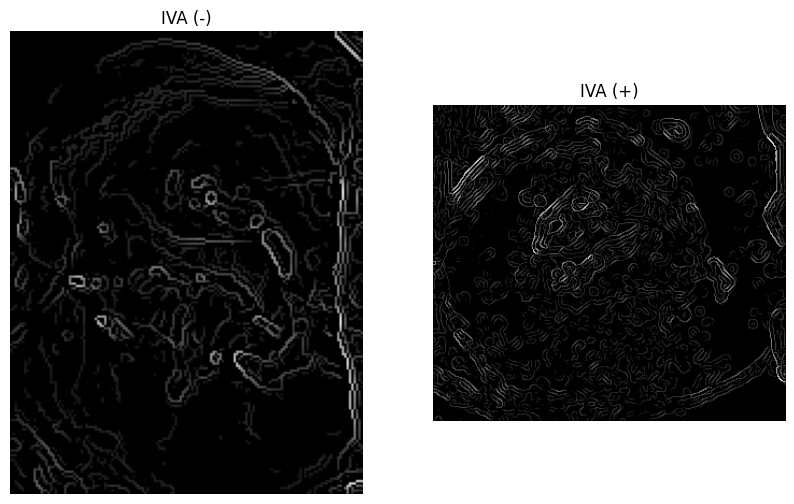

In [7]:
# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 2

# reading images
Image1 = cv2.imread('IVA (-)/IVA Negatif 003.jpg')
Image2 = cv2.imread('IVA (+)/IVA Positif 001.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("IVA (-)")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("IVA (+)")

In [8]:
BATCH_SIZE=32
EPOCH=40
CHANNELS=3
TARGET_SIZE=(224,224)

train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

train_datagen = ImageDataGenerator(
                              rescale=1./255,
                              rotation_range=90
                              #zoom_range=0.3
                            )

val_datagen = ImageDataGenerator(
                              rescale=1./255
                              )
test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                            batch_size=BATCH_SIZE,
                                            target_size=TARGET_SIZE,
                                            seed = 1337,
                                            class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                        batch_size=BATCH_SIZE,
                                        target_size=TARGET_SIZE,
                                        seed = 1337,
                                        class_mode='binary',shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=TARGET_SIZE,
                                          class_mode='binary')

Found 2521 images belonging to 3 classes.
Found 720 images belonging to 3 classes.
Found 361 images belonging to 3 classes.


<Axes: ylabel='count'>

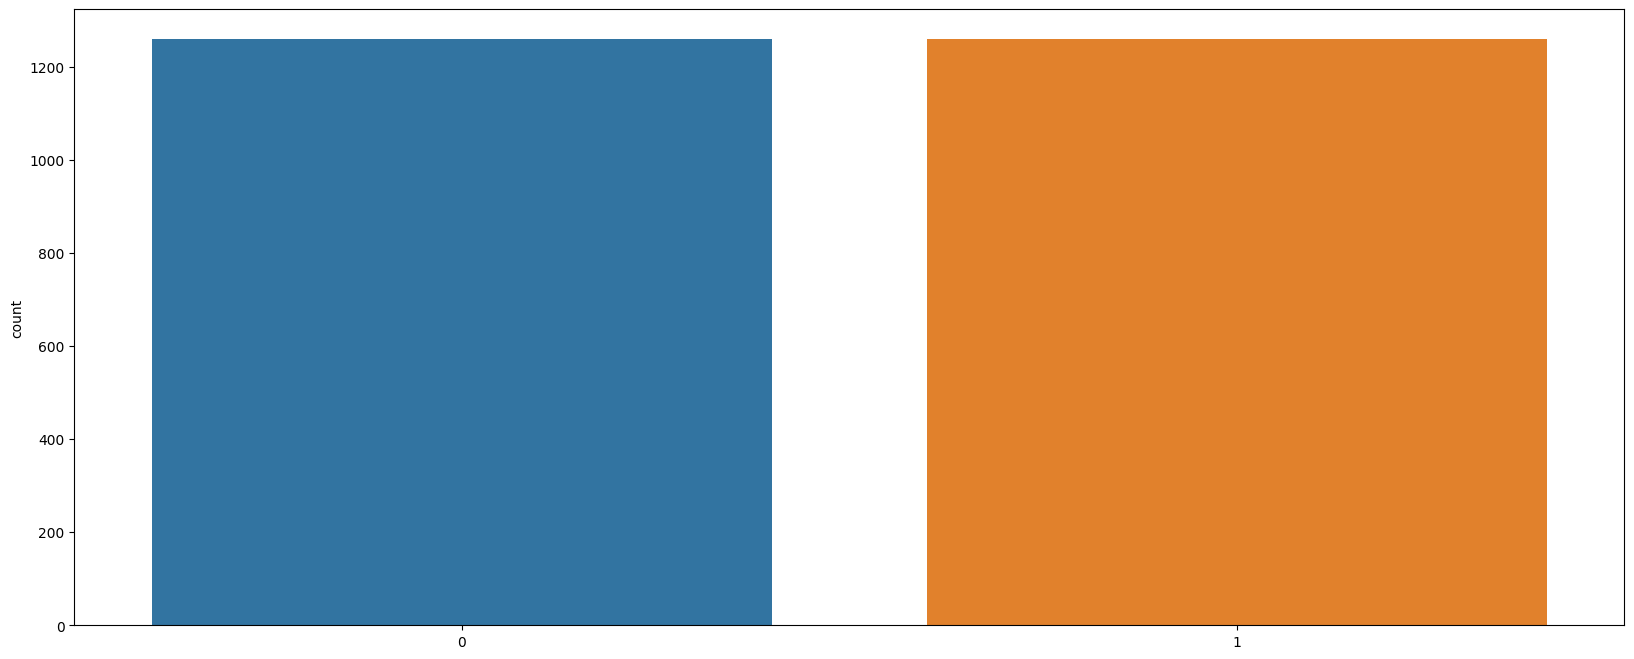

In [10]:
import seaborn as sns
plt.figure(figsize=(20,8))
sns.countplot(x = train_generator.classes)

In [11]:
class_names = list(train_generator.class_indices)
print(class_names)

['IVA (+)', 'IVA (-)', 'output']


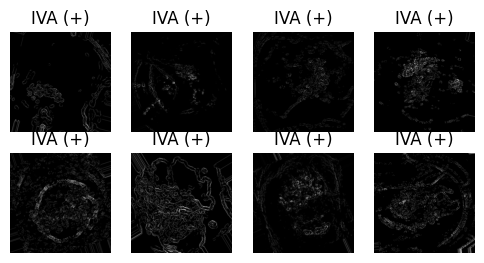

In [12]:
x,y = next(train_generator)
class_names = list(train_generator.class_indices)
# function to plot images
def plotImages(x,y):
    plt.figure(figsize=(6,6))
    for i in range(8):
        plt.subplot(4,4,i+1)
        plt.imshow((x[i] * 255).astype(np.uint8))
        # plt.imshow(x[i])
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")
    plt.show()
plotImages(x,y)

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = ResNet50(weights= None, include_top=False, input_shape= (224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)


early_stopping_monitor = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')

predictions = Dense(1 , activation= 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.1),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_generator, validation_data = val_generator, epochs = EPOCH, steps_per_epoch=60, callbacks=early_stopping_monitor)

Epoch 1/40
60/60 [==============================] - 59s 710ms/step - loss: 2.5671 - acc: 0.5808 - val_loss: 41.2404 - val_acc: 0.5569
Epoch 2/40
60/60 [==============================] - 41s 675ms/step - loss: 0.8173 - acc: 0.7589 - val_loss: 0.9000 - val_acc: 0.5194
Epoch 3/40
60/60 [==============================] - 40s 673ms/step - loss: 0.6438 - acc: 0.8249 - val_loss: 1.3213 - val_acc: 0.5000
Epoch 4/40
60/60 [==============================] - 41s 680ms/step - loss: 0.4912 - acc: 0.8167 - val_loss: 1.6130 - val_acc: 0.5000
Epoch 5/40
60/60 [==============================] - 40s 664ms/step - loss: 0.3322 - acc: 0.8594 - val_loss: 2.2644 - val_acc: 0.4972
Epoch 6/40
60/60 [==============================] - 40s 666ms/step - loss: 0.2892 - acc: 0.8798 - val_loss: 0.6479 - val_acc: 0.7639
Epoch 7/40
60/60 [==============================] - 40s 657ms/step - loss: 0.3813 - acc: 0.8468 - val_loss: 1.4741 - val_acc: 0.5597
Epoch 8/40
60/60 [==============================] - 40s 655ms/step -

In [14]:
model.save('model.h5')

In [15]:
%ls

'57 (1).jpg'   61.jpg   90.jpg     'IVA (-)'/   output/
 57.jpg        66.jpg  'IVA (+)'/   model.h5   'SUBJEK 38 IVA (-).jpg'


In [16]:
model = tf.keras.models.load_model('model.h5')

In [17]:
score = model.evaluate(test_generator)

12/12 [==============================] - 4s 201ms/step - loss: 0.9251 - acc: 0.8172


Text(0.5, 1.0, 'Training and Validation Loss')

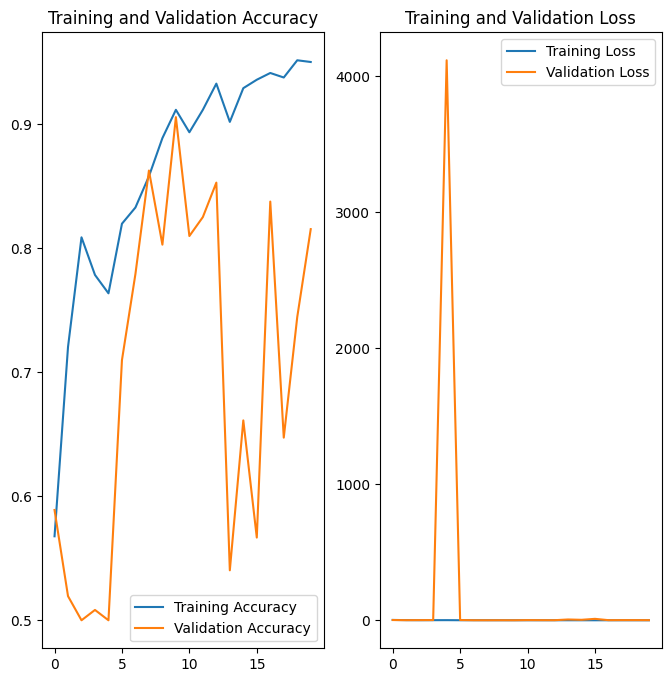

In [18]:
if early_stopping_monitor.stopped_epoch == 0:
  EPOCH_RANGE = EPOCH
else:
  EPOCH_RANGE = early_stopping_monitor.stopped_epoch+1

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH_RANGE), acc, label = 'Training Accuracy')
plt.plot(range(EPOCH_RANGE), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH_RANGE), loss, label = 'Training Loss')
plt.plot(range(EPOCH_RANGE), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

In [19]:
x_test,y_test = test_generator.next()

predictions = model.predict(x_test)

1/1 [==============================] - 1s 904ms/step


In [20]:
len(x_test)

32

In [21]:
len(predictions)

32

In [22]:
predictions

array([[5.6092263e-06],
       [9.9588782e-01],
       [8.8738084e-01],
       [4.1238060e-03],
       [6.4257771e-04],
       [1.8651417e-04],
       [1.8667287e-04],
       [1.0000000e+00],
       [1.1243851e-09],
       [6.2732340e-08],
       [5.6092263e-06],
       [9.9990869e-01],
       [9.9985099e-01],
       [6.8299002e-08],
       [8.3848268e-02],
       [7.1875409e-19],
       [1.8570787e-01],
       [1.1930163e-05],
       [1.9644580e-05],
       [1.2477761e-03],
       [2.9844427e-06],
       [4.9519833e-16],
       [9.9595958e-01],
       [1.1352820e-01],
       [5.3164393e-07],
       [4.7116773e-17],
       [5.3728414e-01],
       [1.3485137e-01],
       [2.5360470e-05],
       [8.5508672e-04],
       [9.9999344e-01],
       [5.6092263e-06]], dtype=float32)

In [23]:
len(y_test)

32

In [24]:
y_test

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

In [25]:
length = len(y_test)

string_y_test=[]

for i in range(length):
  if y_test[i] > 0.5:
    string_y_test.append("IVA (-)")
  else:
    string_y_test.append("IVA (+)")

In [26]:
length = len(predictions)

string_predictions=[]

for i in range(length):
  if predictions[i] > 0.5:
    string_predictions.append("IVA (-)")
  else:
    string_predictions.append("IVA (+)")

In [27]:
len(string_predictions)

32

In [28]:
string_predictions

['IVA (+)',
 'IVA (-)',
 'IVA (-)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (-)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (-)',
 'IVA (-)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (-)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (-)',
 'IVA (+)',
 'IVA (+)',
 'IVA (+)',
 'IVA (-)',
 'IVA (+)']

In [29]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float') / cm.sum(axix=1)[:, np.newaxis]
      print('Normalized confusion matrix')
    else:
      print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plot.ylabel('Prediction label')
    plt.xlabel('Actual label')

In [30]:
print(len(string_y_test))
print(len(string_prediction))

32


NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=string_y_test, y_pred=string_predictions)
conf_mat_plot_labels = ['IVA (-)','IVA (+)']
plot_confusion_matrix(cm=conf_mat, classes=conf_mat_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(string_y_test, string_predictions))

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# defining the canny detector function

# here weak_th and strong_th are thresholds for
# double thresholding step
def Canny_detector(img, weak_th = None, strong_th = None):

    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)

    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)

    # Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # setting the minimum and maximum thresholds
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5

    # getting the dimensions of the input image
    height, width = img.shape

    # Looping through every pixel of the grayscale
    # image
    for i_x in range(width):
        for i_y in range(height):

            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)

            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue

            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0

    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)
    ids = np.zeros_like(img)

    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2

    # finally returning the magnitude of
    # gradients of edges
    return mag

In [ ]:
import numpy as np
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn

  frame = cv2.imread(path)
  canny_img = Canny_detector(frame)

  cv2.imwrite(path,canny_img)

  img = load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = x/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictions = model.predict(images, batch_size=32)

  print(fn)
  print(predictions)
  if predictions[0]>0.5:
       print("IVA (-)")
  else:
       print("IVA (+)")